In [1]:
import random
import numpy as np
from PIL import Image
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, RandomHorizontalFlip, Resize

!pip install torchsummary
from torchsummary import summary

import matplotlib.pyplot as plt
%matplotlib inline

# This line detects if we have a gpu support on our system
device = ("cuda" if torch.cuda.is_available() else "cpu")
print (device)

cuda


### Define our network class

In [2]:

class ShallowNN4Images(nn.Module):
    def __init__(self, input_num, hidden_num, output_num):
        super(ShallowNN4Images, self).__init__()
        # we need to make a vector of input neurons from the image pixels
        self.flatten = nn.Flatten()
        hidden_num2 = (int)(hidden_num/2)
        self.hidden1 = nn.Linear(input_num, hidden_num) # hidden layer
        self.hidden2 = nn.Linear(hidden_num, hidden_num2) # hidden layer
        self.hidden3 = nn.Linear(hidden_num2, hidden_num2)
        self.output = nn.Linear(hidden_num2, output_num) # output layer
        self.sigmoid = nn.Sigmoid() # sigmoid activation function
        self.relu = nn.ReLU() # relu activation function
    
    def forward(self, x):
        x = self.flatten(x)
        # first hidden layer
        x = self.hidden1(x)
        #activation function
        x = self.relu(x) 
        #second hidden layer
        x = self.hidden2(x)
        #activation function
        x = self.relu(x) 
        #third hidden layer
        x = self.hidden3(x)
        #activation function
        x = self.sigmoid(x)
        #output layer
        out = self.output(x)
        return out

input_num = 100 # 10x10 image
hidden_num = 64
output_num = 10 # The output should be the same as the number of classes

model = ShallowNN4Images(input_num, hidden_num, output_num)
model.to(device) # send our model to gpu if available else cpu. 
#print(model)
print (summary(model, (1, 10, 10)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 100]               0
            Linear-2                   [-1, 64]           6,464
              ReLU-3                   [-1, 64]               0
            Linear-4                   [-1, 32]           2,080
              ReLU-5                   [-1, 32]               0
            Linear-6                   [-1, 32]           1,056
           Sigmoid-7                   [-1, 32]               0
            Linear-8                   [-1, 10]             330
Total params: 9,930
Trainable params: 9,930
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04
----------------------------------------------------------------
None


### Define the Loss function

In [3]:
'''
Important Note: Pytorch does not need the network to have the last layer 
 - as a sigmoid layer for BCEWithLogitsLoss (it's computed inside the loss function)
 - as a softmax layer for CrossEntropyLoss (it's computed inside the loss function) 
'''

#binary classification
criterion_binary_case = torch.nn.BCEWithLogitsLoss()
#multi-class classification
criterion_multi_class = torch.nn.CrossEntropyLoss()


## Define your train val test dataset
### Option 1: dataset is a part of pytorch 

In [7]:
from torchvision import datasets, transforms
from torch.utils.data.sampler import  SubsetRandomSampler  #for validation test

#Define a transform to convert to images to tensor and normalize
transform = transforms.Compose([transforms.Resize(size=(10,10)),transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,),)]) #mean and std have to be sequences (e.g., tuples), 
                                                                      # therefore we should add a comma after the values

#transform for train also includes augmentation now!
#,transforms.RandomRotation(degrees=(0, 180)),
transform_train = transforms.Compose([transforms.Resize(size=(10,10)),transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,),)])                      
#Load the data: train and test sets
trainset = datasets.FashionMNIST('data/mnist/F_MNIST_data', download=True, train=True, transform=transform_train)
validset = datasets.FashionMNIST('data/mnist/F_MNIST_data1', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('data/mnist/F_MNIST_data', download=True, train=False, transform=transform)

#Preparing the validation test
indices = list(range(len(trainset)))
np.random.shuffle(indices)
#to get 20% of the train set
split = int(np.floor(0.2 * len(trainset)))
print(len(indices[split:]))
train_sample = SubsetRandomSampler(indices[split:])
valid_sample = SubsetRandomSampler(indices[:split])

#Data Loader
trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=16)
validloader = torch.utils.data.DataLoader(validset, sampler=valid_sample, batch_size=16)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)




100%|██████████| 26421880/26421880 [00:09<00:00, 2781294.78it/s]


Extracting data/mnist/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/mnist/F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 605937.66it/s]


Extracting data/mnist/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3620872.41it/s]


Extracting data/mnist/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 2377742.21it/s]


Extracting data/mnist/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/F_MNIST_data/FashionMNIST/raw



100%|██████████| 26421880/26421880 [00:10<00:00, 2600386.32it/s]


Extracting data/mnist/F_MNIST_data1/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/mnist/F_MNIST_data1/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 583665.56it/s]


Extracting data/mnist/F_MNIST_data1/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/F_MNIST_data1/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2532107.61it/s]


Extracting data/mnist/F_MNIST_data1/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/F_MNIST_data1/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 1322894.07it/s]

Extracting data/mnist/F_MNIST_data1/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/F_MNIST_data1/FashionMNIST/raw

48000


/tmp/ipykernel_10449/2709298000.py:17: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


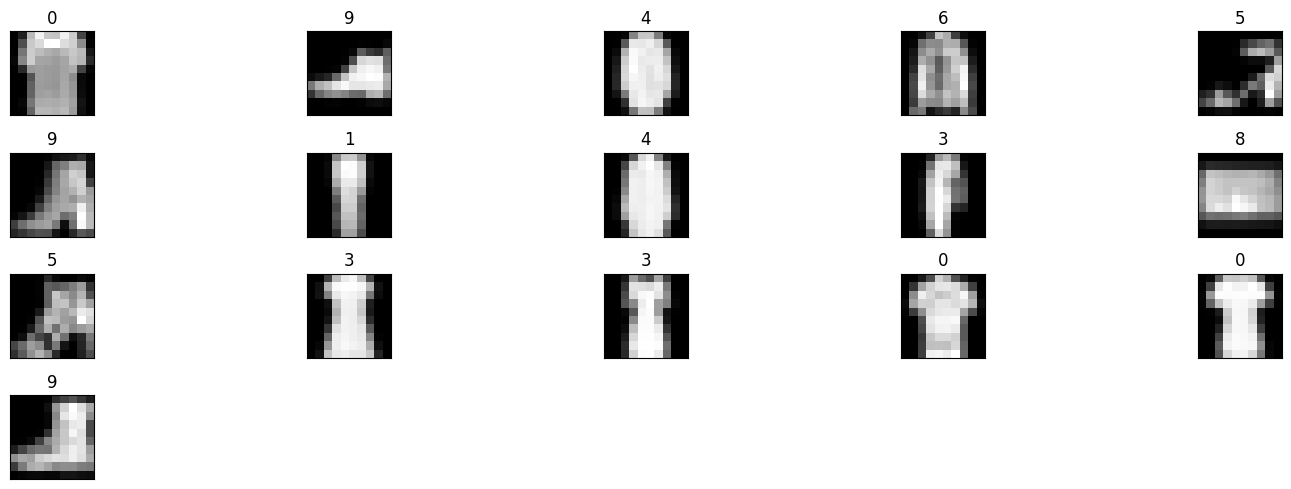

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(trainloader)
print(dataiter)
images, labels = next(dataiter)


fig = plt.figure(figsize=(15,5))
for idx in np.arange(16):
  # xticks=[], yticks=[] is empty to print the images without any ticks around them
  #np.sqeeze : Remove single-dimensional entries from the shape of an array.
  ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
   # .item() gets the value contained in a Tensor
  ax.set_title(labels[idx].item())
  fig.tight_layout()

#### Option 2: A CustomDatasetClass is defined

In [9]:
from torchvision import datasets, transforms
from torch.utils.data.sampler import  SubsetRandomSampler  #for validation test

#fashion mnist dataset is also available in csv format
import pandas as pd
train_csv = pd.read_csv("data/fashion_mnist/fashion-mnist_train.csv")
test_csv = pd.read_csv("data/fashion_mnist/fashion-mnist_test.csv")

#Define a transform to convert to images to tensor and normalize
transform = transforms.Compose([transforms.Resize(size=(10,10)),transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,),)]) #mean and std have to be sequences (e.g., tuples), 
                                                                      # therefore we should add a comma after the values

print (len(train_csv), len(test_csv))

class FashionDataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""
    def __init__(self, data, transform = None):
        """Method to initilaize variables.""" 
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        label = []
        image = []
        for i in self.fashion_MNIST:
             # first column is of labels.
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        # Dimension of Images = 28 * 28 * 1. where height = width = 28 and color_channels = 1.
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

train_set = FashionDataset(train_csv, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,),)]))
test_set = FashionDataset(test_csv, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,),)]))

train_dataset, valid_dataset = torch.utils.data.random_split(train_set, (50000, 10000))

print (len(train_dataset), len(valid_dataset), len(test_set))

60000 10000
50000 10000 10000


In [10]:
 #  defining accuracy function
def accuracy(network, dataloader):
      network.eval()
      total_correct = 0
      total_instances = 0
      for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        predictions = torch.argmax(network(images), dim=1)
        correct_predictions = sum(predictions==labels).item()
        total_correct+=correct_predictions
        total_instances+=len(images)
      return round(total_correct/total_instances, 3)

In [11]:
#!pip install tensorboard
from torch.autograd import Variable
from tqdm import tqdm
import os
from datetime import datetime

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
print(model)

start_epoch = 0
epochs = 50

####
#  creating log
log_dict = {
        'training_loss_per_batch': [],
        'validation_loss_per_batch': [],
        'training_accuracy_per_epoch': [],
        'validation_accuracy_per_epoch': []
    } 


for epoch in range(epochs):
      print(f'Epoch {epoch+1}/{epochs}')
      train_losses = []

      #  training
      print('training...')
      model.train()
      for images, labels in tqdm(trainloader):
        #  sending data to device
        images, labels = images.to(device), labels.to(device)
        #  resetting gradients
        optimizer.zero_grad()
        #  making predictions
        predictions = model(images)
        #  computing loss
        loss = criterion_multi_class(predictions, labels)
        log_dict['training_loss_per_batch'].append(loss.item())
        train_losses.append(loss.item())
        #  computing gradients
        loss.backward()
        #  updating weights
        optimizer.step()
      with torch.no_grad():
        print('deriving training accuracy...')
        #  computing training accuracy
        train_accuracy = accuracy(model, trainloader)
        log_dict['training_accuracy_per_epoch'].append(train_accuracy)

      #  validation
      print('validating...')
      val_losses = []

      #  setting convnet to evaluation mode
      model.eval()

      with torch.no_grad():
        for images, labels in tqdm(validloader):
          #  sending data to device
          images, labels = images.to(device), labels.to(device)
          #  making predictions
          predictions = model(images)
          #  computing loss
          val_loss = criterion_multi_class(predictions, labels)
          log_dict['validation_loss_per_batch'].append(val_loss.item())
          val_losses.append(val_loss.item())
        #  computing accuracy
        print('deriving validation accuracy...')
        val_accuracy = accuracy(model, validloader)
        log_dict['validation_accuracy_per_epoch'].append(val_accuracy)

      train_losses = np.array(train_losses).mean()
      writer.add_scalar("Loss/train", train_losses, epoch)
      val_losses = np.array(val_losses).mean()

      print(f'training_loss: {round(train_losses, 4)}  training_accuracy: '+
      f'{train_accuracy}  validation_loss: {round(val_losses, 4)} '+  
      f'validation_accuracy: {val_accuracy}\n')

writer.close()
      
####
#  saving model
# Get the current datetime
current_datetime = datetime.now()

# Convert the datetime to a string
datetime_string = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

print(datetime_string)

torch.save(model.state_dict(), 'model_Shallow_FMNIST'+datetime_string+'.pth')
print('model saved')
writer.close()

ShallowNN4Images(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden1): Linear(in_features=100, out_features=64, bias=True)
  (hidden2): Linear(in_features=64, out_features=32, bias=True)
  (hidden3): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)
Epoch 1/50
training...


100%|██████████| 3000/3000 [00:11<00:00, 271.17it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:08<00:00, 364.43it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 377.40it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 293.36it/s]


training_loss: 2.3098  training_accuracy: 0.17  validation_loss: 2.2994 validation_accuracy: 0.165

Epoch 2/50
training...


100%|██████████| 3000/3000 [00:13<00:00, 228.22it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:10<00:00, 290.24it/s]


validating...


100%|██████████| 750/750 [00:02<00:00, 319.23it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 309.08it/s]


training_loss: 2.2965  training_accuracy: 0.236  validation_loss: 2.2939 validation_accuracy: 0.225

Epoch 3/50
training...


100%|██████████| 3000/3000 [00:11<00:00, 252.19it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:08<00:00, 340.02it/s]


validating...


100%|██████████| 750/750 [00:02<00:00, 330.64it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 331.09it/s]


training_loss: 2.2902  training_accuracy: 0.284  validation_loss: 2.2864 validation_accuracy: 0.272

Epoch 4/50
training...


100%|██████████| 3000/3000 [00:11<00:00, 256.55it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:08<00:00, 343.29it/s]


validating...


100%|██████████| 750/750 [00:02<00:00, 356.37it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 338.90it/s]


training_loss: 2.2805  training_accuracy: 0.278  validation_loss: 2.2738 validation_accuracy: 0.27

Epoch 5/50
training...


100%|██████████| 3000/3000 [00:11<00:00, 261.38it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:08<00:00, 340.76it/s]


validating...


100%|██████████| 750/750 [00:02<00:00, 357.54it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 336.88it/s]


training_loss: 2.2621  training_accuracy: 0.291  validation_loss: 2.2473 validation_accuracy: 0.284

Epoch 6/50
training...


100%|██████████| 3000/3000 [00:11<00:00, 255.32it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:08<00:00, 345.57it/s]


validating...


100%|██████████| 750/750 [00:02<00:00, 365.38it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 354.14it/s]


training_loss: 2.2192  training_accuracy: 0.29  validation_loss: 2.1802 validation_accuracy: 0.286

Epoch 7/50
training...


100%|██████████| 3000/3000 [00:11<00:00, 269.57it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:08<00:00, 349.02it/s]


validating...


100%|██████████| 750/750 [00:02<00:00, 351.07it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 338.15it/s]


training_loss: 2.1093  training_accuracy: 0.317  validation_loss: 2.0196 validation_accuracy: 0.313

Epoch 8/50
training...


100%|██████████| 3000/3000 [00:11<00:00, 268.35it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:08<00:00, 334.04it/s]


validating...


100%|██████████| 750/750 [00:02<00:00, 342.50it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 320.65it/s]


training_loss: 1.9217  training_accuracy: 0.381  validation_loss: 1.8253 validation_accuracy: 0.382

Epoch 9/50
training...


100%|██████████| 3000/3000 [00:11<00:00, 263.43it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:08<00:00, 337.14it/s]


validating...


100%|██████████| 750/750 [00:02<00:00, 354.07it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 335.86it/s]


training_loss: 1.7525  training_accuracy: 0.395  validation_loss: 1.6785 validation_accuracy: 0.403

Epoch 10/50
training...


100%|██████████| 3000/3000 [00:10<00:00, 272.90it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:08<00:00, 345.98it/s]


validating...


100%|██████████| 750/750 [00:02<00:00, 366.70it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 368.93it/s]


training_loss: 1.6189  training_accuracy: 0.444  validation_loss: 1.5532 validation_accuracy: 0.454

Epoch 11/50
training...


100%|██████████| 3000/3000 [00:11<00:00, 266.30it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:08<00:00, 355.47it/s]


validating...


100%|██████████| 750/750 [00:02<00:00, 370.96it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 302.25it/s]


training_loss: 1.5017  training_accuracy: 0.485  validation_loss: 1.4459 validation_accuracy: 0.493

Epoch 12/50
training...


100%|██████████| 3000/3000 [00:11<00:00, 264.83it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:08<00:00, 353.10it/s]


validating...


100%|██████████| 750/750 [00:02<00:00, 347.10it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 320.22it/s]


training_loss: 1.4075  training_accuracy: 0.515  validation_loss: 1.3635 validation_accuracy: 0.518

Epoch 13/50
training...


100%|██████████| 3000/3000 [00:10<00:00, 275.06it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:08<00:00, 344.90it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 428.75it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:01<00:00, 424.09it/s]


training_loss: 1.3349  training_accuracy: 0.527  validation_loss: 1.2971 validation_accuracy: 0.529

Epoch 14/50
training...


100%|██████████| 3000/3000 [00:09<00:00, 321.31it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:07<00:00, 409.76it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 434.94it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:01<00:00, 395.74it/s]


training_loss: 1.2762  training_accuracy: 0.53  validation_loss: 1.2429 validation_accuracy: 0.536

Epoch 15/50
training...


100%|██████████| 3000/3000 [00:08<00:00, 334.12it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:07<00:00, 408.56it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 443.21it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:01<00:00, 430.49it/s]


training_loss: 1.2269  training_accuracy: 0.546  validation_loss: 1.1958 validation_accuracy: 0.553

Epoch 16/50
training...


100%|██████████| 3000/3000 [00:09<00:00, 330.51it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:07<00:00, 413.38it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 429.86it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:01<00:00, 429.72it/s]


training_loss: 1.1845  training_accuracy: 0.564  validation_loss: 1.1552 validation_accuracy: 0.573

Epoch 17/50
training...


100%|██████████| 3000/3000 [00:09<00:00, 311.22it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:07<00:00, 412.29it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 440.55it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:01<00:00, 416.31it/s]


training_loss: 1.1474  training_accuracy: 0.573  validation_loss: 1.1194 validation_accuracy: 0.585

Epoch 18/50
training...


100%|██████████| 3000/3000 [00:08<00:00, 333.79it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:07<00:00, 413.04it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 440.40it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:01<00:00, 425.17it/s]


training_loss: 1.1143  training_accuracy: 0.589  validation_loss: 1.0881 validation_accuracy: 0.604

Epoch 19/50
training...


100%|██████████| 3000/3000 [00:09<00:00, 322.46it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:07<00:00, 416.80it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 429.09it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:01<00:00, 401.81it/s]


training_loss: 1.0847  training_accuracy: 0.594  validation_loss: 1.0592 validation_accuracy: 0.609

Epoch 20/50
training...


100%|██████████| 3000/3000 [00:09<00:00, 324.21it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:07<00:00, 419.23it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 413.73it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:01<00:00, 412.56it/s]


training_loss: 1.0575  training_accuracy: 0.607  validation_loss: 1.0334 validation_accuracy: 0.62

Epoch 21/50
training...


100%|██████████| 3000/3000 [00:09<00:00, 325.40it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:07<00:00, 405.76it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 378.49it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 349.27it/s]


training_loss: 1.0325  training_accuracy: 0.61  validation_loss: 1.0097 validation_accuracy: 0.624

Epoch 22/50
training...


100%|██████████| 3000/3000 [00:10<00:00, 285.24it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:08<00:00, 367.13it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 379.44it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 336.44it/s]


training_loss: 1.0095  training_accuracy: 0.619  validation_loss: 0.9875 validation_accuracy: 0.631

Epoch 23/50
training...


100%|██████████| 3000/3000 [00:10<00:00, 292.86it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:08<00:00, 354.33it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 441.59it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:01<00:00, 422.55it/s]


training_loss: 0.9882  training_accuracy: 0.627  validation_loss: 0.9671 validation_accuracy: 0.639

Epoch 24/50
training...


100%|██████████| 3000/3000 [00:09<00:00, 328.76it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:07<00:00, 423.07it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 439.38it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:01<00:00, 453.90it/s]


training_loss: 0.9684  training_accuracy: 0.638  validation_loss: 0.9485 validation_accuracy: 0.649

Epoch 25/50
training...


100%|██████████| 3000/3000 [00:09<00:00, 302.13it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:08<00:00, 363.17it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 405.34it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:01<00:00, 381.76it/s]


training_loss: 0.9496  training_accuracy: 0.636  validation_loss: 0.9299 validation_accuracy: 0.64

Epoch 26/50
training...


100%|██████████| 3000/3000 [00:10<00:00, 290.17it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:08<00:00, 368.14it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 387.86it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 350.61it/s]


training_loss: 0.9313  training_accuracy: 0.642  validation_loss: 0.9125 validation_accuracy: 0.648

Epoch 27/50
training...


100%|██████████| 3000/3000 [00:09<00:00, 302.59it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:08<00:00, 368.00it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 398.08it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 368.29it/s]


training_loss: 0.9137  training_accuracy: 0.65  validation_loss: 0.8956 validation_accuracy: 0.654

Epoch 28/50
training...


100%|██████████| 3000/3000 [00:10<00:00, 284.34it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:07<00:00, 383.98it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 390.58it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:01<00:00, 379.57it/s]


training_loss: 0.8971  training_accuracy: 0.66  validation_loss: 0.8799 validation_accuracy: 0.665

Epoch 29/50
training...


100%|██████████| 3000/3000 [00:10<00:00, 290.34it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:07<00:00, 377.98it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 380.57it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 372.37it/s]


training_loss: 0.8818  training_accuracy: 0.664  validation_loss: 0.8665 validation_accuracy: 0.67

Epoch 30/50
training...


100%|██████████| 3000/3000 [00:10<00:00, 299.11it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:07<00:00, 390.46it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 399.18it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 371.41it/s]


training_loss: 0.8676  training_accuracy: 0.667  validation_loss: 0.8532 validation_accuracy: 0.67

Epoch 31/50
training...


100%|██████████| 3000/3000 [00:10<00:00, 291.84it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:08<00:00, 374.90it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 384.19it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 369.63it/s]


training_loss: 0.8545  training_accuracy: 0.675  validation_loss: 0.8405 validation_accuracy: 0.677

Epoch 32/50
training...


100%|██████████| 3000/3000 [00:10<00:00, 298.05it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:08<00:00, 370.90it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 386.89it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:01<00:00, 377.26it/s]


training_loss: 0.8425  training_accuracy: 0.681  validation_loss: 0.8291 validation_accuracy: 0.687

Epoch 33/50
training...


100%|██████████| 3000/3000 [00:10<00:00, 296.44it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:07<00:00, 381.00it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 400.73it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 363.29it/s]


training_loss: 0.8313  training_accuracy: 0.687  validation_loss: 0.8189 validation_accuracy: 0.694

Epoch 34/50
training...


100%|██████████| 3000/3000 [00:10<00:00, 298.23it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:07<00:00, 377.45it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 392.24it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 368.67it/s]


training_loss: 0.8209  training_accuracy: 0.687  validation_loss: 0.8092 validation_accuracy: 0.694

Epoch 35/50
training...


100%|██████████| 3000/3000 [00:10<00:00, 294.71it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:08<00:00, 373.32it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 393.53it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 372.34it/s]


training_loss: 0.8114  training_accuracy: 0.692  validation_loss: 0.8 validation_accuracy: 0.698

Epoch 36/50
training...


100%|██████████| 3000/3000 [00:10<00:00, 291.84it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:07<00:00, 392.28it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 386.64it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 370.25it/s]


training_loss: 0.8025  training_accuracy: 0.695  validation_loss: 0.7912 validation_accuracy: 0.702

Epoch 37/50
training...


100%|██████████| 3000/3000 [00:10<00:00, 299.80it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:08<00:00, 367.13it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 403.07it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:01<00:00, 378.40it/s]


training_loss: 0.7941  training_accuracy: 0.699  validation_loss: 0.783 validation_accuracy: 0.706

Epoch 38/50
training...


100%|██████████| 3000/3000 [00:10<00:00, 290.11it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:08<00:00, 368.63it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 391.79it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:01<00:00, 380.10it/s]


training_loss: 0.7862  training_accuracy: 0.703  validation_loss: 0.7752 validation_accuracy: 0.709

Epoch 39/50
training...


100%|██████████| 3000/3000 [00:10<00:00, 289.08it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:07<00:00, 376.13it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 398.03it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 372.17it/s]


training_loss: 0.7787  training_accuracy: 0.706  validation_loss: 0.7682 validation_accuracy: 0.712

Epoch 40/50
training...


100%|██████████| 3000/3000 [00:09<00:00, 301.81it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:08<00:00, 370.22it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 393.51it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 360.04it/s]


training_loss: 0.7718  training_accuracy: 0.71  validation_loss: 0.761 validation_accuracy: 0.716

Epoch 41/50
training...


100%|██████████| 3000/3000 [00:10<00:00, 291.18it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:08<00:00, 371.90it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 386.75it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 372.04it/s]


training_loss: 0.7652  training_accuracy: 0.713  validation_loss: 0.7549 validation_accuracy: 0.719

Epoch 42/50
training...


100%|██████████| 3000/3000 [00:10<00:00, 291.82it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:07<00:00, 379.26it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 393.39it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:01<00:00, 375.11it/s]


training_loss: 0.759  training_accuracy: 0.716  validation_loss: 0.7484 validation_accuracy: 0.723

Epoch 43/50
training...


100%|██████████| 3000/3000 [00:10<00:00, 293.39it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:08<00:00, 371.16it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 379.91it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 354.60it/s]


training_loss: 0.7532  training_accuracy: 0.717  validation_loss: 0.7429 validation_accuracy: 0.725

Epoch 44/50
training...


100%|██████████| 3000/3000 [00:10<00:00, 287.26it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:08<00:00, 370.59it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 375.11it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:01<00:00, 378.24it/s]


training_loss: 0.7477  training_accuracy: 0.722  validation_loss: 0.7372 validation_accuracy: 0.73

Epoch 45/50
training...


100%|██████████| 3000/3000 [00:10<00:00, 294.12it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:08<00:00, 362.69it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 386.93it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 358.97it/s]


training_loss: 0.7426  training_accuracy: 0.724  validation_loss: 0.7318 validation_accuracy: 0.731

Epoch 46/50
training...


100%|██████████| 3000/3000 [00:10<00:00, 291.64it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:08<00:00, 362.59it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 382.70it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 367.44it/s]


training_loss: 0.7377  training_accuracy: 0.726  validation_loss: 0.7268 validation_accuracy: 0.732

Epoch 47/50
training...


100%|██████████| 3000/3000 [00:10<00:00, 297.49it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:07<00:00, 378.41it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 399.49it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 350.30it/s]


training_loss: 0.7328  training_accuracy: 0.729  validation_loss: 0.7223 validation_accuracy: 0.735

Epoch 48/50
training...


100%|██████████| 3000/3000 [00:10<00:00, 296.08it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:07<00:00, 382.57it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 411.20it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 364.73it/s]


training_loss: 0.7282  training_accuracy: 0.73  validation_loss: 0.7179 validation_accuracy: 0.736

Epoch 49/50
training...


100%|██████████| 3000/3000 [00:10<00:00, 289.35it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:07<00:00, 375.13it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 398.78it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:02<00:00, 366.13it/s]


training_loss: 0.7238  training_accuracy: 0.732  validation_loss: 0.7132 validation_accuracy: 0.737

Epoch 50/50
training...


100%|██████████| 3000/3000 [00:10<00:00, 293.44it/s]


deriving training accuracy...


100%|██████████| 3000/3000 [00:07<00:00, 380.79it/s]


validating...


100%|██████████| 750/750 [00:01<00:00, 401.67it/s]


deriving validation accuracy...


100%|██████████| 750/750 [00:01<00:00, 394.06it/s]

training_loss: 0.7193  training_accuracy: 0.735  validation_loss: 0.7085 validation_accuracy: 0.743

2024-04-21_15-41-25
model saved


### Simple convolutional neural network

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10)
        )
    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)
        return x

cnn_model= SimpleCNN()
cnn_model.to(device)
summary(cnn_model, (3, 10, 10))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 10, 10]             896
              ReLU-2           [-1, 32, 10, 10]               0
            Conv2d-3           [-1, 64, 10, 10]          18,496
              ReLU-4           [-1, 64, 10, 10]               0
         MaxPool2d-5             [-1, 64, 5, 5]               0
            Conv2d-6            [-1, 128, 5, 5]          73,856
              ReLU-7            [-1, 128, 5, 5]               0
            Conv2d-8            [-1, 128, 5, 5]         147,584
              ReLU-9            [-1, 128, 5, 5]               0
        MaxPool2d-10            [-1, 128, 2, 2]               0
           Conv2d-11            [-1, 256, 2, 2]         295,168
             ReLU-12            [-1, 256, 2, 2]               0
           Conv2d-13            [-1, 256, 2, 2]         590,080
             ReLU-14            [-1, 25

In [14]:
from torchvision import datasets, transforms
from torch.utils.data.sampler import  SubsetRandomSampler  #for validation test


#Define a transform to convert to images to tensor and normalize
transform = transforms.Compose([transforms.Resize(size=(10,10)),transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,),)]) #mean and std have to be sequences (e.g., tuples), 
                                                                      # therefore we should add a comma after the values

#transform for train also includes augmentation now!
#,transforms.RandomRotation(degrees=(0, 180)),
transform_train = transforms.Compose([transforms.Resize(size=(10,10)),transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,),)])                      
#Load the data: train and test sets
trainset = datasets.CIFAR10('data/cifar10/train', download=True, train=True, transform=transform_train)
validset = datasets.CIFAR10('data/cifar10/valid', download=True, train=True, transform=transform)
testset = datasets.CIFAR10('data/cifar10/test', download=True, train=False, transform=transform)

#Preparing the validation test
indices = list(range(len(trainset)))
np.random.shuffle(indices)
#to get 20% of the train set
split = int(np.floor(0.2 * len(trainset)))
print(len(indices[split:]))
train_sample = SubsetRandomSampler(indices[split:])
valid_sample = SubsetRandomSampler(indices[:split])

#Data Loader
trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=16)
validloader = torch.utils.data.DataLoader(validset, sampler=valid_sample, batch_size=16)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


100%|██████████| 170498071/170498071 [00:48<00:00, 3484436.76it/s]


Extracting data/cifar10/train/cifar-10-python.tar.gz to data/cifar10/train


100%|██████████| 170498071/170498071 [01:26<00:00, 1970289.00it/s]


Extracting data/cifar10/valid/cifar-10-python.tar.gz to data/cifar10/valid


100%|██████████| 170498071/170498071 [02:40<00:00, 1063280.13it/s]


Extracting data/cifar10/test/cifar-10-python.tar.gz to data/cifar10/test
40000


In [15]:
#!pip install tensorboard
from torch.autograd import Variable
from tqdm import tqdm
import os
from datetime import datetime

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

learning_rate = 0.001
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=learning_rate)
print(cnn_model)

start_epoch = 0
epochs = 50

####
#  creating log
log_dict = {
        'training_loss_per_batch': [],
        'validation_loss_per_batch': [],
        'training_accuracy_per_epoch': [],
        'validation_accuracy_per_epoch': []
    } 


for epoch in range(epochs):
      print(f'Epoch {epoch+1}/{epochs}')
      train_losses = []

      #  training
      print('training...')
      cnn_model.train()
      for images, labels in tqdm(trainloader):
        #  sending data to device
        images, labels = images.to(device), labels.to(device)
        #  resetting gradients
        optimizer.zero_grad()
        #  making predictions
        predictions = cnn_model(images)
        #  computing loss
        loss = criterion_multi_class(predictions, labels)
        log_dict['training_loss_per_batch'].append(loss.item())
        train_losses.append(loss.item())
        #  computing gradients
        loss.backward()
        #  updating weights
        optimizer.step()
      with torch.no_grad():
        print('deriving training accuracy...')
        #  computing training accuracy
        train_accuracy = accuracy(cnn_model, trainloader)
        log_dict['training_accuracy_per_epoch'].append(train_accuracy)

      #  validation
      print('validating...')
      val_losses = []

      #  setting convnet to evaluation mode
      cnn_model.eval()

      with torch.no_grad():
        for images, labels in tqdm(validloader):
          #  sending data to device
          images, labels = images.to(device), labels.to(device)
          #  making predictions
          predictions = cnn_model(images)
          #  computing loss
          val_loss = criterion_multi_class(predictions, labels)
          log_dict['validation_loss_per_batch'].append(val_loss.item())
          val_losses.append(val_loss.item())
        #  computing accuracy
        print('deriving validation accuracy...')
        val_accuracy = accuracy(cnn_model, validloader)
        log_dict['validation_accuracy_per_epoch'].append(val_accuracy)

      train_losses = np.array(train_losses).mean()
      writer.add_scalar("Loss/train", train_losses, epoch)
      val_losses = np.array(val_losses).mean()

      print(f'training_loss: {round(train_losses, 4)}  training_accuracy: '+
      f'{train_accuracy}  validation_loss: {round(val_losses, 4)} '+  
      f'validation_accuracy: {val_accuracy}\n')

writer.close()
      
####
#  saving model
# Get the current datetime
current_datetime = datetime.now()

# Convert the datetime to a string
datetime_string = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

print(datetime_string)

torch.save(cnn_model.state_dict(), 'model_Shallow_FMNIST'+datetime_string+'.pth')
print('model saved')
writer.close()

SimpleCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=256, out_features=512,

100%|██████████| 2500/2500 [00:14<00:00, 176.81it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:07<00:00, 317.70it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 282.14it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 270.35it/s]


training_loss: 2.3035  training_accuracy: 0.1  validation_loss: 2.3028 validation_accuracy: 0.1

Epoch 2/50
training...


100%|██████████| 2500/2500 [00:13<00:00, 185.10it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:09<00:00, 271.48it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 279.41it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 267.30it/s]


training_loss: 2.3031  training_accuracy: 0.1  validation_loss: 2.3026 validation_accuracy: 0.1

Epoch 3/50
training...


100%|██████████| 2500/2500 [00:14<00:00, 173.57it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:09<00:00, 259.65it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 282.59it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 276.10it/s]


training_loss: 2.3028  training_accuracy: 0.1  validation_loss: 2.3026 validation_accuracy: 0.1

Epoch 4/50
training...


100%|██████████| 2500/2500 [00:13<00:00, 189.97it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:09<00:00, 270.18it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 257.16it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 267.41it/s]


training_loss: 2.3027  training_accuracy: 0.1  validation_loss: 2.3026 validation_accuracy: 0.1

Epoch 5/50
training...


100%|██████████| 2500/2500 [00:14<00:00, 177.08it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:09<00:00, 269.71it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 283.11it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 269.55it/s]


training_loss: 2.3026  training_accuracy: 0.1  validation_loss: 2.3026 validation_accuracy: 0.1

Epoch 6/50
training...


100%|██████████| 2500/2500 [00:13<00:00, 184.30it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:09<00:00, 268.78it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 273.16it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 270.40it/s]


training_loss: 2.3026  training_accuracy: 0.1  validation_loss: 2.3027 validation_accuracy: 0.1

Epoch 7/50
training...


100%|██████████| 2500/2500 [00:14<00:00, 176.22it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 284.92it/s]


validating...


100%|██████████| 625/625 [00:01<00:00, 318.49it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 279.72it/s]


training_loss: 2.3026  training_accuracy: 0.1  validation_loss: 2.3027 validation_accuracy: 0.1

Epoch 8/50
training...


100%|██████████| 2500/2500 [00:14<00:00, 173.42it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:09<00:00, 270.97it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 276.76it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 254.04it/s]


training_loss: 2.3026  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 9/50
training...


100%|██████████| 2500/2500 [00:13<00:00, 182.58it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:09<00:00, 271.71it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 287.55it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 274.76it/s]


training_loss: 2.3026  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 10/50
training...


100%|██████████| 2500/2500 [00:13<00:00, 183.36it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 280.31it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 265.65it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 274.68it/s]


training_loss: 2.3026  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 11/50
training...


100%|██████████| 2500/2500 [00:13<00:00, 189.54it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 298.07it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 281.50it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:01<00:00, 324.25it/s]


training_loss: 2.3026  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 12/50
training...


100%|██████████| 2500/2500 [00:13<00:00, 192.29it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 304.37it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 307.19it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 295.59it/s]


training_loss: 2.3026  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 13/50
training...


100%|██████████| 2500/2500 [00:12<00:00, 197.70it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 288.71it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 287.17it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 279.42it/s]


training_loss: 2.3026  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 14/50
training...


100%|██████████| 2500/2500 [00:12<00:00, 197.31it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 289.28it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 299.61it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 294.82it/s]


training_loss: 2.3026  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 15/50
training...


100%|██████████| 2500/2500 [00:12<00:00, 196.70it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 287.67it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 294.44it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 289.22it/s]


training_loss: 2.3026  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 16/50
training...


100%|██████████| 2500/2500 [00:12<00:00, 193.20it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 290.46it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 291.34it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 272.02it/s]


training_loss: 2.3026  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 17/50
training...


100%|██████████| 2500/2500 [00:12<00:00, 197.94it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 289.80it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 283.83it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 285.47it/s]


training_loss: 2.3026  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 18/50
training...


100%|██████████| 2500/2500 [00:12<00:00, 197.00it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 284.41it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 304.51it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 287.57it/s]


training_loss: 2.3026  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 19/50
training...


100%|██████████| 2500/2500 [00:12<00:00, 194.61it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 290.06it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 258.98it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 261.89it/s]


training_loss: 2.3026  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 20/50
training...


100%|██████████| 2500/2500 [00:13<00:00, 186.46it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 287.71it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 286.79it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 282.19it/s]


training_loss: 2.3026  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 21/50
training...


100%|██████████| 2500/2500 [00:13<00:00, 183.36it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 285.21it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 291.41it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 281.75it/s]


training_loss: 2.3026  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 22/50
training...


100%|██████████| 2500/2500 [00:12<00:00, 194.91it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 289.32it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 303.51it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 284.19it/s]


training_loss: 2.3026  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 23/50
training...


100%|██████████| 2500/2500 [00:13<00:00, 188.40it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 283.36it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 283.96it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 279.35it/s]


training_loss: 2.3025  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 24/50
training...


100%|██████████| 2500/2500 [00:13<00:00, 191.68it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 282.25it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 294.26it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 272.76it/s]


training_loss: 2.3025  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 25/50
training...


100%|██████████| 2500/2500 [00:13<00:00, 185.10it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 281.36it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 302.73it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 268.80it/s]


training_loss: 2.3025  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 26/50
training...


100%|██████████| 2500/2500 [00:13<00:00, 190.75it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 282.16it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 291.44it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 282.76it/s]


training_loss: 2.3025  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 27/50
training...


100%|██████████| 2500/2500 [00:13<00:00, 187.12it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:09<00:00, 276.24it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 290.19it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 286.96it/s]


training_loss: 2.3025  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 28/50
training...


100%|██████████| 2500/2500 [00:13<00:00, 186.62it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 284.94it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 290.88it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 286.26it/s]


training_loss: 2.3025  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 29/50
training...


100%|██████████| 2500/2500 [00:12<00:00, 200.29it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 308.37it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 311.39it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 302.93it/s]


training_loss: 2.3025  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 30/50
training...


100%|██████████| 2500/2500 [00:12<00:00, 201.07it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 303.06it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 305.87it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 308.02it/s]


training_loss: 2.3025  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 31/50
training...


100%|██████████| 2500/2500 [00:12<00:00, 200.90it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 299.87it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 312.43it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 299.66it/s]


training_loss: 2.3025  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 32/50
training...


100%|██████████| 2500/2500 [00:12<00:00, 206.64it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 311.38it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 307.37it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 299.64it/s]


training_loss: 2.3025  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 33/50
training...


100%|██████████| 2500/2500 [00:11<00:00, 210.78it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 283.82it/s]


validating...


100%|██████████| 625/625 [00:01<00:00, 313.02it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 302.55it/s]


training_loss: 2.3025  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 34/50
training...


100%|██████████| 2500/2500 [00:12<00:00, 205.71it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 298.46it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 308.29it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 281.66it/s]


training_loss: 2.3025  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 35/50
training...


100%|██████████| 2500/2500 [00:12<00:00, 205.01it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 296.20it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 301.78it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 300.17it/s]


training_loss: 2.3025  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 36/50
training...


100%|██████████| 2500/2500 [00:12<00:00, 203.34it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 301.80it/s]


validating...


100%|██████████| 625/625 [00:01<00:00, 314.47it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 296.51it/s]


training_loss: 2.3025  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 37/50
training...


100%|██████████| 2500/2500 [00:12<00:00, 204.51it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:07<00:00, 312.67it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 311.36it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 297.55it/s]


training_loss: 2.3025  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 38/50
training...


100%|██████████| 2500/2500 [00:12<00:00, 205.38it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 294.70it/s]


validating...


100%|██████████| 625/625 [00:01<00:00, 321.81it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 301.58it/s]


training_loss: 2.3025  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 39/50
training...


100%|██████████| 2500/2500 [00:11<00:00, 208.98it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 298.11it/s]


validating...


100%|██████████| 625/625 [00:01<00:00, 317.51it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 305.75it/s]


training_loss: 2.3025  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 40/50
training...


100%|██████████| 2500/2500 [00:12<00:00, 204.98it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 299.33it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 308.86it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 296.57it/s]


training_loss: 2.3025  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 41/50
training...


100%|██████████| 2500/2500 [00:12<00:00, 201.89it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 300.82it/s]


validating...


100%|██████████| 625/625 [00:01<00:00, 319.79it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 305.76it/s]


training_loss: 2.3025  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 42/50
training...


100%|██████████| 2500/2500 [00:11<00:00, 216.04it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 305.74it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 311.89it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 312.09it/s]


training_loss: 2.3025  training_accuracy: 0.101  validation_loss: 2.3027 validation_accuracy: 0.096

Epoch 43/50
training...


100%|██████████| 2500/2500 [00:11<00:00, 211.79it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 299.13it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 300.28it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 277.85it/s]


training_loss: 2.3025  training_accuracy: 0.101  validation_loss: 2.3026 validation_accuracy: 0.096

Epoch 44/50
training...


100%|██████████| 2500/2500 [00:12<00:00, 202.69it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 301.91it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 307.25it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 289.64it/s]


training_loss: 2.3025  training_accuracy: 0.101  validation_loss: 2.3026 validation_accuracy: 0.096

Epoch 45/50
training...


100%|██████████| 2500/2500 [00:12<00:00, 204.77it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 300.27it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 301.09it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 296.65it/s]


training_loss: 2.3025  training_accuracy: 0.101  validation_loss: 2.3026 validation_accuracy: 0.096

Epoch 46/50
training...


100%|██████████| 2500/2500 [00:11<00:00, 220.09it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 296.39it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 304.02it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 299.59it/s]


training_loss: 2.3025  training_accuracy: 0.101  validation_loss: 2.3026 validation_accuracy: 0.096

Epoch 47/50
training...


100%|██████████| 2500/2500 [00:12<00:00, 203.91it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 302.49it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 310.62it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 303.58it/s]


training_loss: 2.3025  training_accuracy: 0.101  validation_loss: 2.3026 validation_accuracy: 0.096

Epoch 48/50
training...


100%|██████████| 2500/2500 [00:12<00:00, 199.95it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 299.05it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 299.98it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 308.61it/s]


training_loss: 2.3024  training_accuracy: 0.101  validation_loss: 2.3026 validation_accuracy: 0.096

Epoch 49/50
training...


100%|██████████| 2500/2500 [00:11<00:00, 216.38it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 295.33it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 304.08it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 295.58it/s]


training_loss: 2.3024  training_accuracy: 0.101  validation_loss: 2.3026 validation_accuracy: 0.096

Epoch 50/50
training...


100%|██████████| 2500/2500 [00:11<00:00, 208.71it/s]


deriving training accuracy...


100%|██████████| 2500/2500 [00:08<00:00, 304.08it/s]


validating...


100%|██████████| 625/625 [00:02<00:00, 304.66it/s]


deriving validation accuracy...


100%|██████████| 625/625 [00:02<00:00, 297.31it/s]

training_loss: 2.3024  training_accuracy: 0.101  validation_loss: 2.3026 validation_accuracy: 0.096

2024-04-21_16-11-01
model saved
